In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.linalg import block_diag

import random
from itertools import combinations
from math import floor

In [2]:
from src.expander_codes import *

### Читаем графы из входных файлов

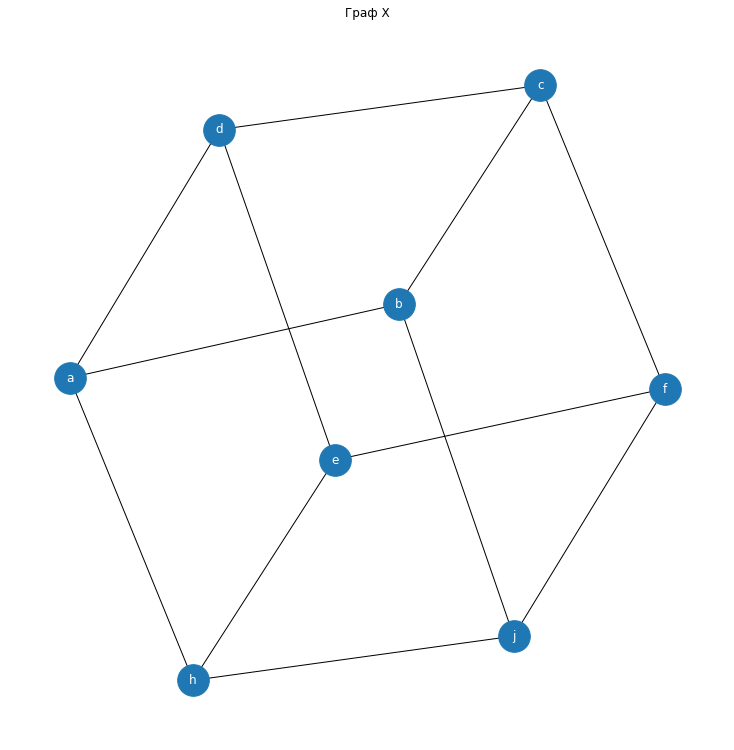

In [3]:
filepath_X = 'input/X_edges.txt'
X = read_graph_from_csv(filepath_X)
draw_graph(X, title='Граф Х')

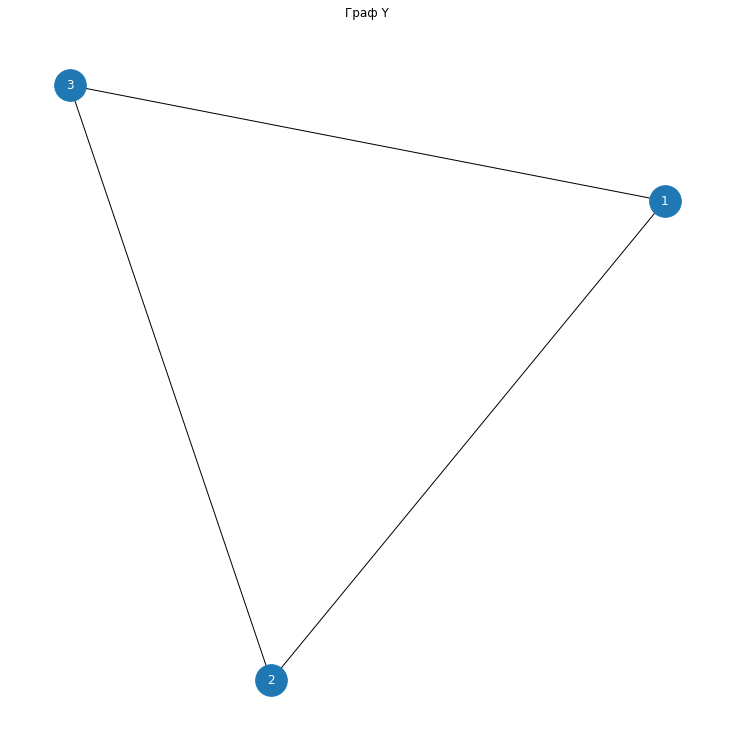

In [4]:
filepath_Y = 'input/Y_edges.txt'
Y = read_graph_from_csv(filepath_Y)
draw_graph(Y, title='Граф Y')

In [5]:
check_input_graphs(X, Y)

True

## Алгоритм зиг-заг (из книги "Expander Families and Cayley Graphs"):

### Шаг 1: создаем блочно-диагональную матрицу G размера $|X|\cdot|Y|\times|X|\cdot|Y|$ . Блоки матрицы - это матрицы смежности графа Y

In [6]:
G_np_arr = block_diag(*(X.number_of_nodes() * [nx.to_numpy_array(Y)]))
G_np_arr

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

### Переводим матрицу смежности в граф и присваиваем соответствующие названия вершин

In [7]:
G = nx.from_numpy_array(G_np_arr)

XY = nx.cartesian_product(X, Y)
XY.nodes

NodeView((('a', 1), ('a', 2), ('a', 3), ('b', 1), ('b', 2), ('b', 3), ('d', 1), ('d', 2), ('d', 3), ('h', 1), ('h', 2), ('h', 3), ('c', 1), ('c', 2), ('c', 3), ('j', 1), ('j', 2), ('j', 3), ('f', 1), ('f', 2), ('f', 3), ('e', 1), ('e', 2), ('e', 3)))

In [8]:
mapping = {old_label:new_label for old_label, new_label in enumerate(list(XY.nodes))}
G = nx.relabel_nodes(G, mapping)

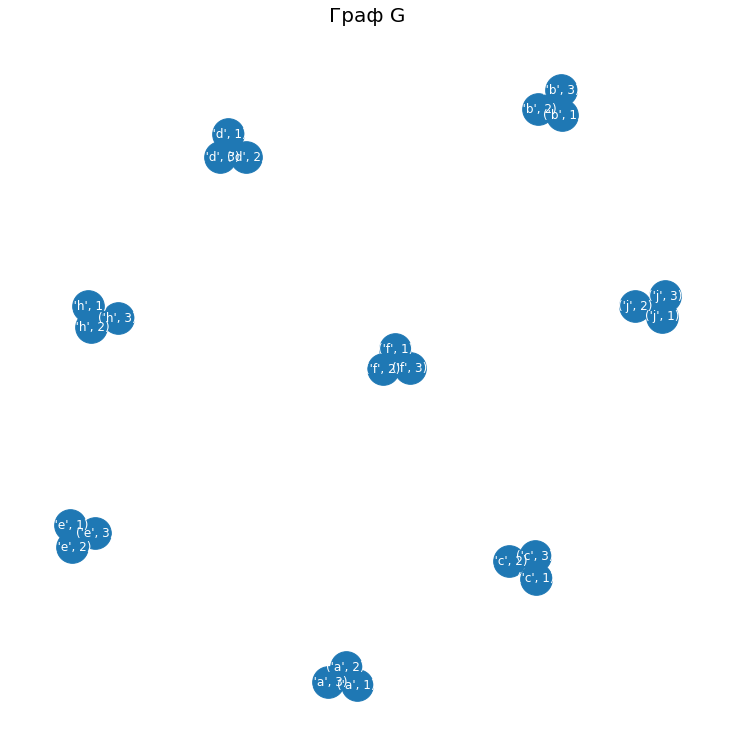

In [9]:
plt.figure(1,figsize=(10,10)) 
nx.draw(G, node_size=1000, font_color='white', with_labels=True) 
plt.title('Граф G', fontsize=20);

### Шаг 2: Генерируем рандомный лэйблинг вокруг каждой вершины из графа Х. Создаем таблицу для лэйблинга: вход - $(x_i, y_k)$ выход - $(x_i, x_j)$, где $x_i$ смежна с $x_j$

In [10]:
num_of_nodes_Y = Y.number_of_nodes()

labeling = list()
for n, nbrs in X.adj.items():
    node_labeling = random.sample(list(Y.nodes), num_of_nodes_Y)
    labels = list(zip([n] * num_of_nodes_Y, node_labeling))
    edges = list(zip([n] * num_of_nodes_Y, list(nbrs)))
    labeling.extend(list(zip(labels, edges)))    

In [11]:
labeling

[(('a', 3), ('a', 'b')),
 (('a', 1), ('a', 'd')),
 (('a', 2), ('a', 'h')),
 (('b', 1), ('b', 'a')),
 (('b', 2), ('b', 'c')),
 (('b', 3), ('b', 'j')),
 (('d', 1), ('d', 'a')),
 (('d', 3), ('d', 'c')),
 (('d', 2), ('d', 'e')),
 (('h', 1), ('h', 'a')),
 (('h', 2), ('h', 'e')),
 (('h', 3), ('h', 'j')),
 (('c', 3), ('c', 'b')),
 (('c', 2), ('c', 'd')),
 (('c', 1), ('c', 'f')),
 (('j', 3), ('j', 'b')),
 (('j', 1), ('j', 'f')),
 (('j', 2), ('j', 'h')),
 (('f', 2), ('f', 'c')),
 (('f', 1), ('f', 'e')),
 (('f', 3), ('f', 'j')),
 (('e', 1), ('e', 'd')),
 (('e', 2), ('e', 'f')),
 (('e', 3), ('e', 'h'))]

### Аггрегируем таблицу лэйблинга по ребрам и получаем таблицу смежных вершин

In [12]:
df = pd.DataFrame(labeling)
df[1] = [tuple(sorted(x)) for x in df[1]]
grouped_df = df.groupby(1)[0].agg(list)

grouped_df

1
(a, b)    [(a, 3), (b, 1)]
(a, d)    [(a, 1), (d, 1)]
(a, h)    [(a, 2), (h, 1)]
(b, c)    [(b, 2), (c, 3)]
(b, j)    [(b, 3), (j, 3)]
(c, d)    [(d, 3), (c, 2)]
(c, f)    [(c, 1), (f, 2)]
(d, e)    [(d, 2), (e, 1)]
(e, f)    [(f, 1), (e, 2)]
(e, h)    [(h, 2), (e, 3)]
(f, j)    [(j, 1), (f, 3)]
(h, j)    [(h, 3), (j, 2)]
Name: 0, dtype: object

### Создаем граф H на основе саггрегированной таблицы и декартового произведения вершин графов X, Y

In [13]:
H = nx.Graph()
H.add_nodes_from(XY.nodes)
H.add_edges_from(grouped_df.values)

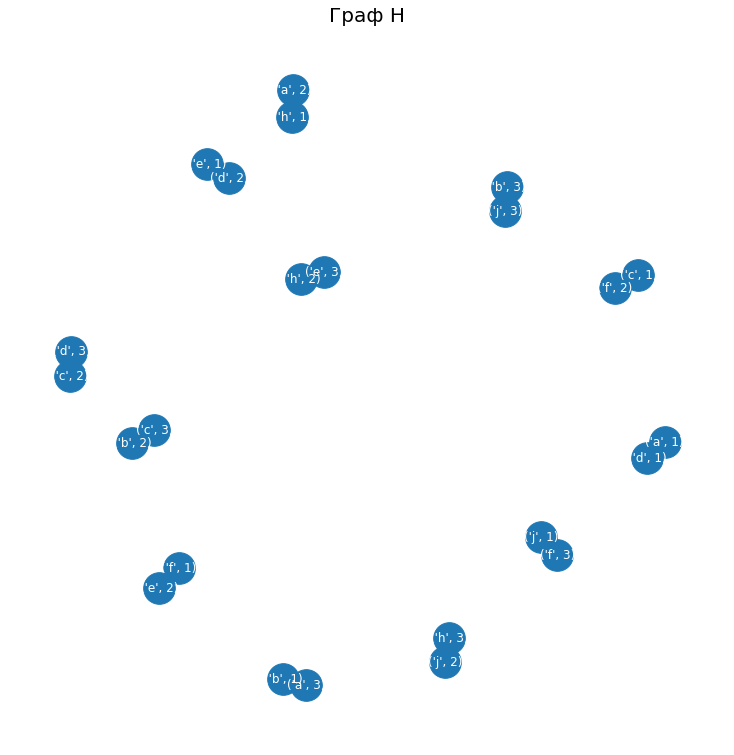

In [14]:
plt.figure(1,figsize=(10,10)) 
nx.draw(H, node_size=1000, font_color='white', with_labels=True)
plt.title('Граф H', fontsize=20);

### Переводим граф H в матрицу смежности

In [15]:
H_np_arr = nx.to_numpy_array(H)

### Шаг 3: Получаем зиг-заг произведения путем перемножения матриц смежностей: $G\cdot H\cdot G$ 

In [16]:
zig_zag_np_arr = G_np_arr @ H_np_arr @ G_np_arr

In [17]:
zig_zag = nx.from_numpy_array(zig_zag_np_arr)

In [18]:
mapping = {old_label:new_label for old_label, new_label in enumerate(list(XY.nodes))}
zig_zag = nx.relabel_nodes(zig_zag, mapping)

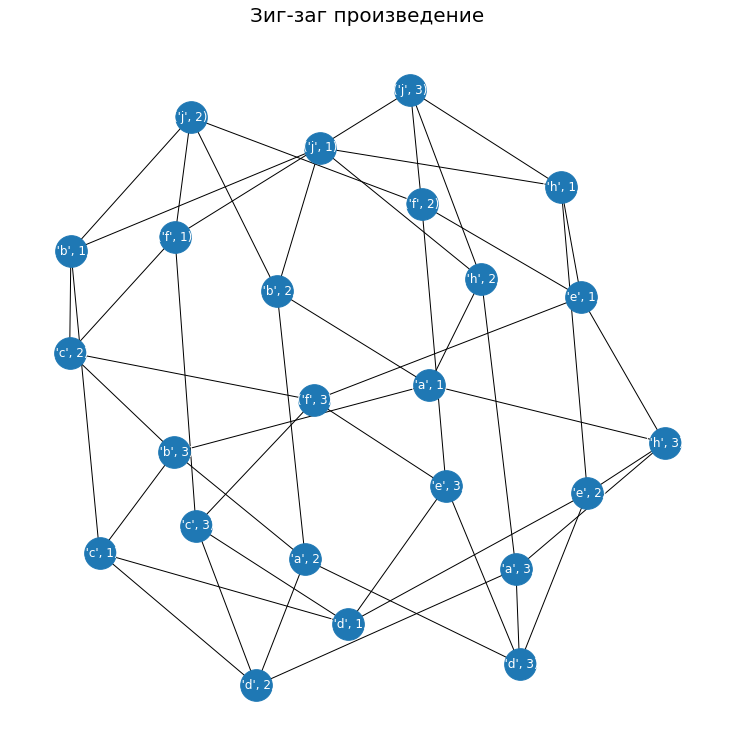

In [19]:
plt.figure(3,figsize=(10,10)) 
nx.draw(zig_zag, node_size=1000, font_color='white', with_labels=True)
plt.title('Зиг-заг произведение', fontsize=20);

## Проверка условий, необходимых к задаче кодирования

### Проверка на двудольность и регулярность графа

In [20]:
nx.algorithms.bipartite.is_bipartite(zig_zag)

True

In [21]:
nx.is_regular(zig_zag)

True

In [22]:
zig_zag.degree()

DegreeView({('a', 1): 4, ('a', 2): 4, ('a', 3): 4, ('b', 1): 4, ('b', 2): 4, ('b', 3): 4, ('d', 1): 4, ('d', 2): 4, ('d', 3): 4, ('h', 1): 4, ('h', 2): 4, ('h', 3): 4, ('c', 1): 4, ('c', 2): 4, ('c', 3): 4, ('j', 1): 4, ('j', 2): 4, ('j', 3): 4, ('f', 1): 4, ('f', 2): 4, ('f', 3): 4, ('e', 1): 4, ('e', 2): 4, ('e', 3): 4})

### Левая (L) и правая (R) доли графа

In [23]:
L, R = nx.algorithms.bipartite.sets(zig_zag)
L, R

({('a', 1),
  ('a', 2),
  ('a', 3),
  ('c', 1),
  ('c', 2),
  ('c', 3),
  ('e', 1),
  ('e', 2),
  ('e', 3),
  ('j', 1),
  ('j', 2),
  ('j', 3)},
 {('b', 1),
  ('b', 2),
  ('b', 3),
  ('d', 1),
  ('d', 2),
  ('d', 3),
  ('f', 1),
  ('f', 2),
  ('f', 3),
  ('h', 1),
  ('h', 2),
  ('h', 3)})

In [24]:
if len(L) < len(R):
    L, R = R, L

In [25]:
node, degree = zip(*nx.degree(zig_zag, L))

In [26]:
d = set(degree).pop()
d

4

### Создаем подмножества $S \subset L$, $|S|\leq \gamma n$

In [28]:
# set_of_nodes_L = set(L)
# max_size_of_subset_S = floor(gamma * len(L))
# subsets_S = create_subsets_from(set_of_nodes_L, max_size_of_subset_S)

### Проверка граничного условия: $|\partial_v S|\geq d \alpha |S|$ 

In [29]:
def is_satisfy_boundary_condition(graph, subsets, d, alpha):
    for subset in subsets:
        node_boundary = list(nx.algorithms.node_boundary(graph, subset))
        if len(node_boundary) < d * alpha * len(subset):
            # print(f'for subset: {subset}, d = {d}, alpha = {alpha}, node_boundary = {node_boundary}')
            return False
    return True

In [30]:
zig_zag.number_of_nodes()

24

In [31]:
delta = 0.001
n = zig_zag.number_of_nodes()
gammas = np.linspace(0.1, 0.9, 9)
gammas

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [32]:
epsilon = 1/5
alphas = np.linspace(epsilon + delta, 0.9, 8)
alphas

array([0.201     , 0.30085714, 0.40071429, 0.50057143, 0.60042857,
       0.70028571, 0.80014286, 0.9       ])

In [33]:
gamma_alpha = list()
for gamma in gammas:
    set_of_nodes_L = set(L)
    max_size_of_subset_S = floor(gamma * len(L))
    subsets_S = create_subsets_from(set_of_nodes_L, max_size_of_subset_S)
    
    for alpha in alphas:
        if is_satisfy_boundary_condition(zig_zag, subsets_S, d, alpha):
            gamma_alpha.append((gamma, alpha))
            print(f'gamma:{gamma:.3f}, alpha:{alpha:.3f}')

gamma:0.100, alpha:0.201
gamma:0.100, alpha:0.301
gamma:0.100, alpha:0.401
gamma:0.100, alpha:0.501
gamma:0.100, alpha:0.600
gamma:0.100, alpha:0.700
gamma:0.100, alpha:0.800
gamma:0.100, alpha:0.900
gamma:0.200, alpha:0.201
gamma:0.200, alpha:0.301
gamma:0.200, alpha:0.401
gamma:0.200, alpha:0.501
gamma:0.200, alpha:0.600
gamma:0.200, alpha:0.700
gamma:0.300, alpha:0.201
gamma:0.300, alpha:0.301
gamma:0.300, alpha:0.401
gamma:0.400, alpha:0.201
gamma:0.400, alpha:0.301
gamma:0.400, alpha:0.401
gamma:0.500, alpha:0.201
gamma:0.500, alpha:0.301
gamma:0.600, alpha:0.201
gamma:0.600, alpha:0.301
gamma:0.700, alpha:0.201
gamma:0.700, alpha:0.301
gamma:0.800, alpha:0.201
gamma:0.800, alpha:0.301
gamma:0.900, alpha:0.201


## Спектральный пробел

#### Матрица Лапласа: $L = D - A$

In [ ]:
print(nx.laplacian_matrix(zig_zag).toarray())

In [ ]:
lambd = nx.algebraic_connectivity(zig_zag)
lambd

## Алгоритм вычисления изопериметрической константы

### Создаем подмножества $S \subset V$, $|S|\leq \frac{|V|}{2}$

In [ ]:
def create_subsets_from(set_of_nodes, max_size_subset):
    subsets = set(combinations(set_of_nodes, 1))
    
    for i in range(1, max_size_subset):
        subsets = subsets.union(set(combinations(set_of_nodes, i + 1)))    
        
    return subsets

In [ ]:
set_of_nodes_X = set(X.nodes)
max_size_of_subset_X = floor(len(set_of_nodes_X) / 2)
subsets_X = create_subsets_from(set_of_nodes_X, max_size_of_subset_X)

In [ ]:
# def adjacency_table(graph):
#     adjacency_table = dict()
#     for n, nbrs in graph.adj.items():
#         adjacency_table[n] = set(nbrs)
        
#     return adjacency_table

In [ ]:
# adjacency_table_X = adjacency_table(X)
# adjacency_table_X

### Вычисление изопериметрической константы путем перебора каждого подмножества $S$

In [ ]:
def calculate_isoperimetric(graph, subsets):
    isoperimetric_num = np.inf

    for subset in subsets:
        # edge_boundary = list(nx.algorithms.edge_boundary(graph, subset))
        edge_expansion = nx.algorithms.cuts.edge_expansion(graph, subset)
        # print(f'for subset: {subset}, edge bound: {edge_bound}\n\n')
        isoperimetric_num = min(isoperimetric_num, edge_expansion)

        # isoperimetric_num = min(isoperimetric_num, len(edge_boundary) / len(subset))
        
    return isoperimetric_num

#### Для входного графа Х:

In [ ]:
calculate_isoperimetric(X, subsets_X)

#### Для входного графа Y:

In [ ]:
set_of_nodes_Y = set(Y.nodes)
max_size_of_subset_Y = floor(len(set_of_nodes_Y) / 2)
subsets_Y = create_subsets_from(set_of_nodes_Y, max_size_of_subset_Y)

In [ ]:
# adjacency_table_Y = adjacency_table(Y)

In [ ]:
calculate_isoperimetric(Y, subsets_Y)

#### Для графа, полученного зиг-заг произведением:

In [ ]:
set_of_nodes_zig_zag = set(zig_zag.nodes)
max_size_of_subset_zig_zag = floor(len(set_of_nodes_zig_zag) / 2)
subsets_zig_zag = create_subsets_from(set_of_nodes_zig_zag, max_size_of_subset_zig_zag)

In [ ]:
# adjacency_table_zig_zag = adjacency_table(zig_zag)

In [ ]:
calculate_isoperimetric(zig_zag, subsets_zig_zag)

In [ ]:
nx.algebraic_connectivity(X)

In [ ]:
nx.algebraic_connectivity(Y)

In [ ]:
nx.algebraic_connectivity(zig_zag)